# ABS Monthly Labour Force 6202

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Python-environment" data-toc-modified-id="Python-environment-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Python environment</a></span></li><li><span><a href="#Get-data-from-ABS" data-toc-modified-id="Get-data-from-ABS-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Get data from ABS</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot</a></span><ul class="toc-item"><li><span><a href="#Headline-charts" data-toc-modified-id="Headline-charts-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Headline charts</a></span></li><li><span><a href="#State-comparisons" data-toc-modified-id="State-comparisons-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>State comparisons</a></span></li><li><span><a href="#Gendered-comparisons" data-toc-modified-id="Gendered-comparisons-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Gendered comparisons</a></span></li></ul></li><li><span><a href="#Finished" data-toc-modified-id="Finished-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Finished</a></span></li></ul></div>

## Python set-up

In [1]:
# system imports
import sys
import platform
import psutil
from pathlib import Path

# analytic imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# abs specific imports
from abs_common import *

# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# plotting stuff
plt.style.use('ggplot')

In [2]:
# cache directory
CACHE_DIR = '../cache'
Path(CACHE_DIR).mkdir(parents=True, exist_ok=True)

# charts directory
CHART_DIR = '../charts'
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)

## Python environment

In [3]:
N = 50
print('-'*N)
print(f"System:         {platform.system()}")
print(f"Release:        {platform.release()}")
#print(f"Version:        {platform.version()}")
print(f"Machine:        {platform.machine()}")
print(f"Processor:      {platform.processor()}")
print(f"RAM:            {round(psutil.virtual_memory().total / 1024**3)}GB")
print('-'*N)
print(f"Python:         {platform.python_version()}")
print(f"Psutil:         {psutil.__version__}")
print(f"Pandas:         {pd.__version__}")
print(f"Numpy:          {np.__version__}")
print(f"Matplotlib:     {mpl.__version__}")
print('-'*N)

--------------------------------------------------
System:         Darwin
Release:        20.1.0
Machine:        x86_64
Processor:      i386
RAM:            64GB
--------------------------------------------------
Python:         3.8.3
Psutil:         5.7.0
Pandas:         1.0.5
Numpy:          1.18.5
Matplotlib:     3.2.2
--------------------------------------------------


## Get data from ABS

In [4]:
# do the data capture and extraction to a DataFrame
url_template = ('https://www.abs.gov.au/statistics/labour/'
                'employment-and-unemployment/labour-force-australia/'
                'MONTH-YEAR/6202_all%20spreadsheet.zip')

meta, data = get_ABS_meta_and_data(url_template, CACHE_DIR)

File has been cached already
File for oct-2020 of size 41.7 MB


## Plot

### Headline charts

Note: with COVID, the ABS has stopped publishing the Trend series.  

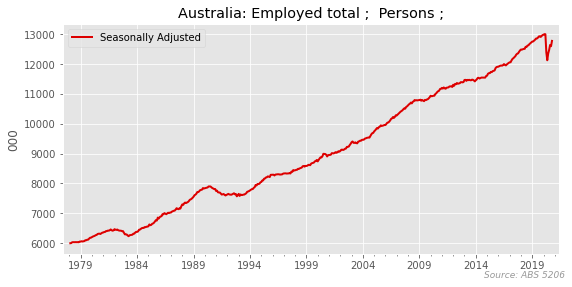

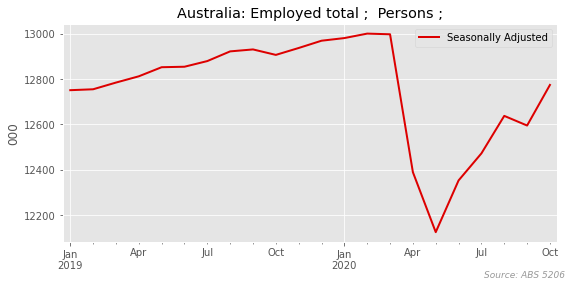

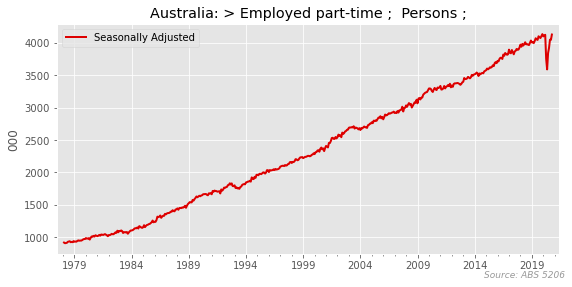

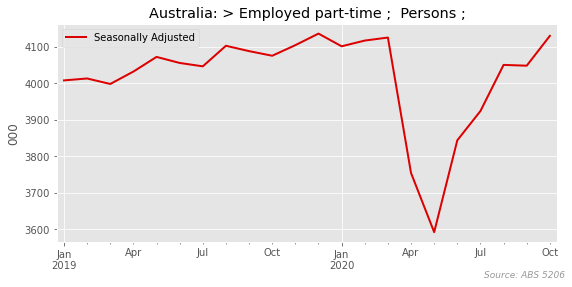

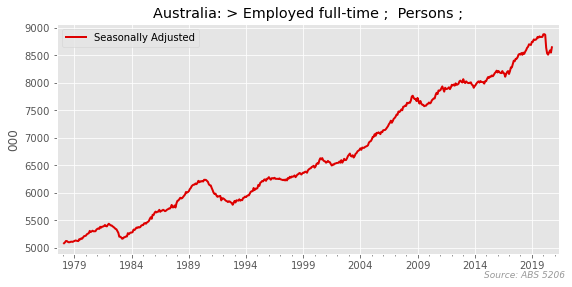

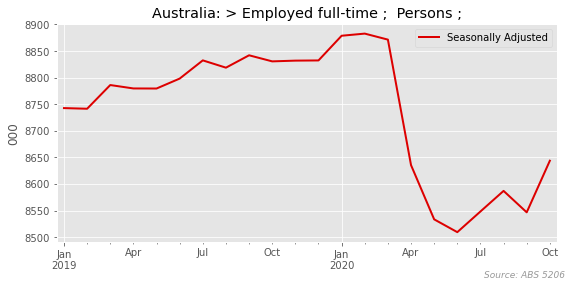

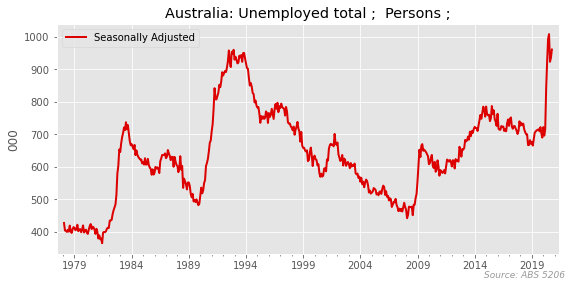

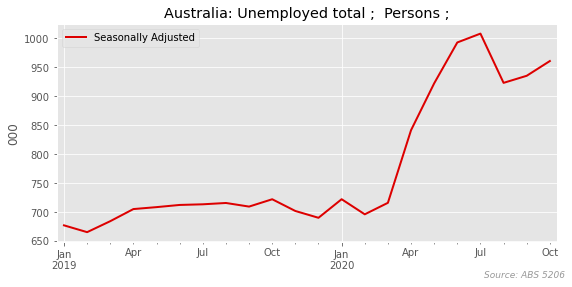

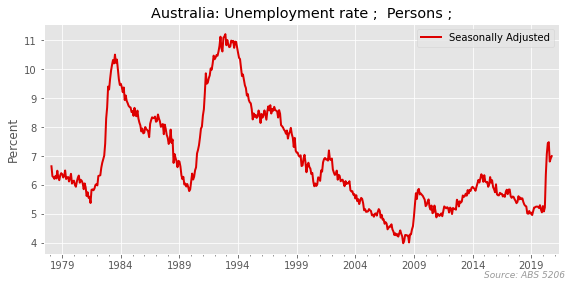

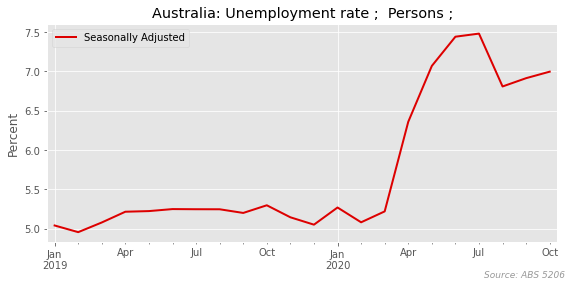

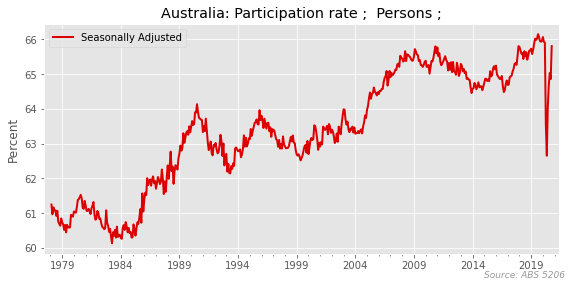

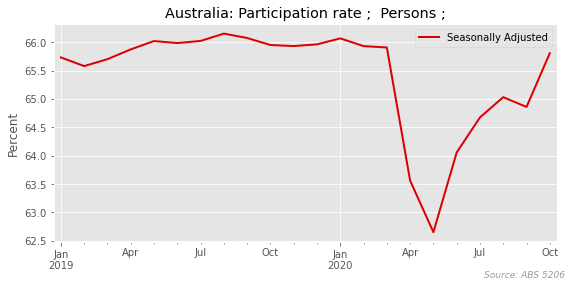

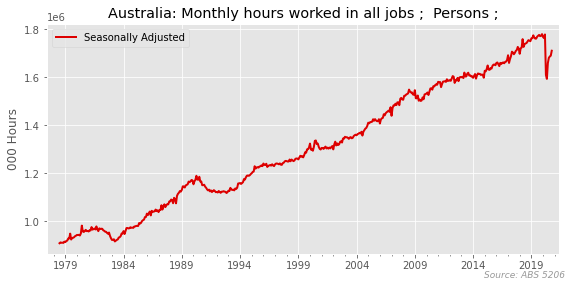

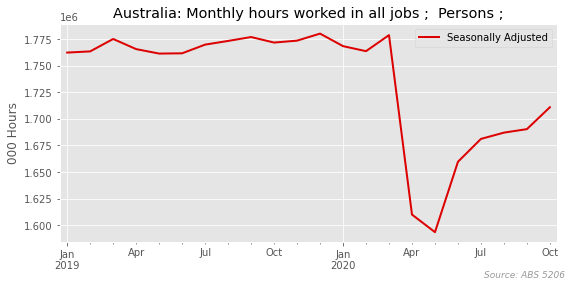

In [5]:
headlines = {
    # data item                                       # table number
    'Employed total ;  Persons ;':                    '1',
    '> Employed part-time ;  Persons ;':              '1',
    '> Employed full-time ;  Persons ;':              '1',
    'Unemployed total ;  Persons ;':                  '1',
    'Unemployment rate ;  Persons ;':                 '1', 
    'Participation rate ;  Persons ;':                '1',
    'Monthly hours worked in all jobs ;  Persons ;':  '19',
}
frames = (data, data[data.index >= pd.Timestamp('2019-01-01')])
tags = ('full', 'recent')

for headline, table in headlines.items():
    for df, tag in zip(frames, tags):

        # get meta data
        seasadj, units = get_identifier(meta, headline, 
                                        "Seasonally Adjusted", 
                                        table)
        
        # plot actual data 
        ax = df[[seasadj]].plot(c='#dd0000', lw=2)
    
        # annotate plot
        ax.legend(['Seasonally Adjusted'], loc='best')
        title = f'Australia: {headline}'
        finalise_plot(ax, title, units, tag, CHART_DIR)

### State comparisons 

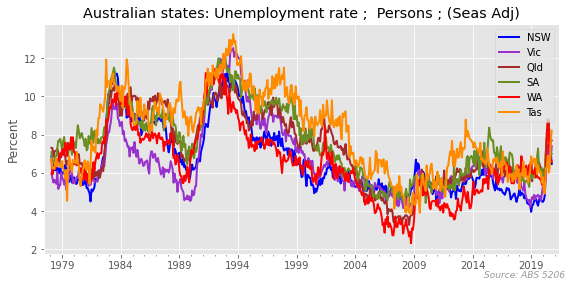

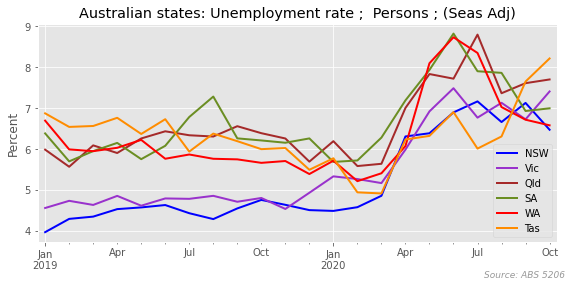

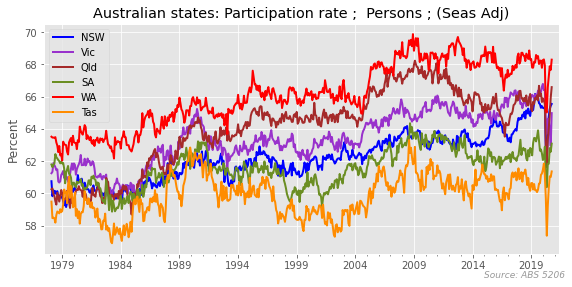

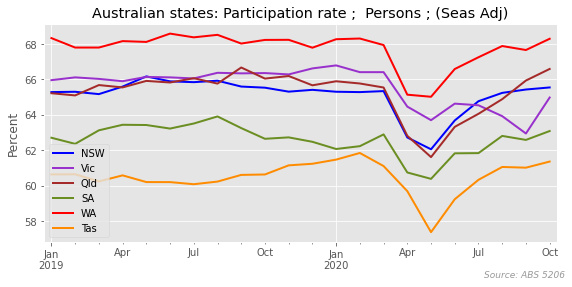

In [6]:
states = {
    # state                     # table
    "NSW":                      '4',
    "Vic":                      '5',
    "Qld":                      "6",
    "SA":                       "7",
    "WA":                       "8",
    "Tas":                      "9",
}

plots = [
    'Unemployment rate ;  Persons ;', 
    'Participation rate ;  Persons ;',
]

colours = ['blue', 'darkorchid', 'brown', 'olivedrab', 'red', 
           'darkorange', 'darkgoldenrod', 'teal',]

frames = (data, data[data.index >= pd.Timestamp('2019-01-01')])
tags = ('full', 'recent')

for plot in plots:
    collection = []
    for state, table in states.items():
        id, units = get_identifier(meta, plot, "Seasonally Adjusted", table)
        collection.append(id)
        
    for frame, tag in zip(frames, tags):
        ax = frame[collection].plot(lw=2, color=colours)

        # annotate plot
        ax.legend(states.keys(), loc='best')
        title = f'Australian states: {plot} (Seas Adj)'
        finalise_plot(ax, title, units, tag, CHART_DIR)

### Gendered comparisons

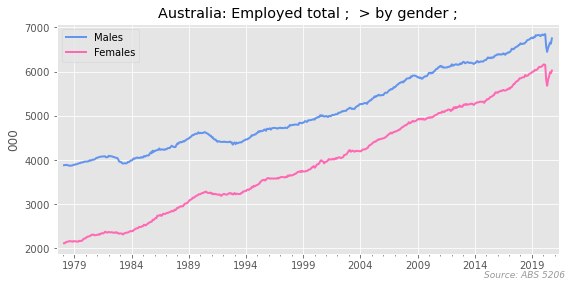

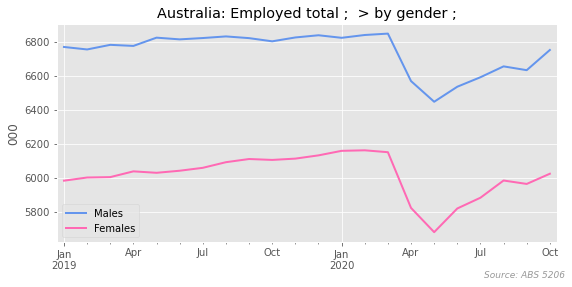

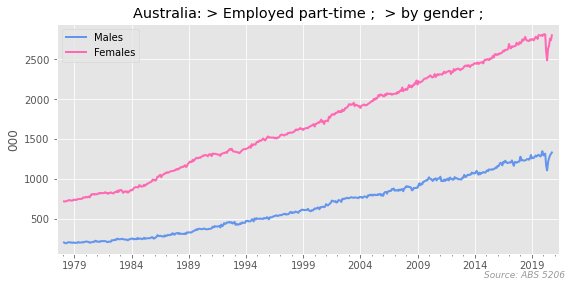

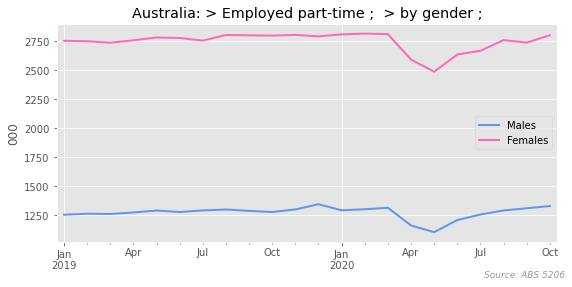

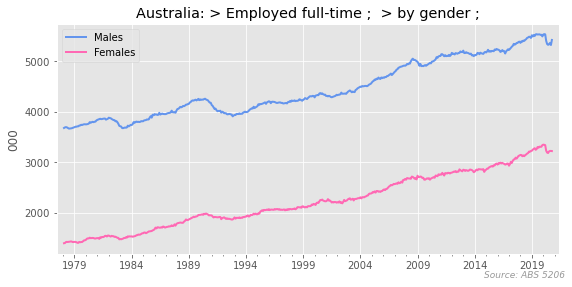

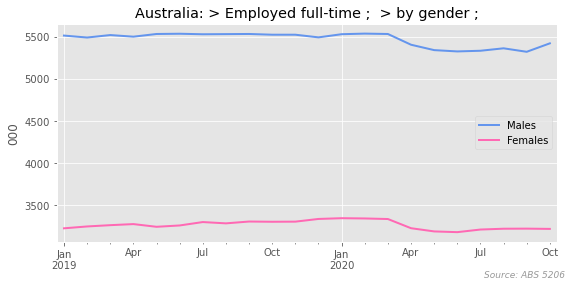

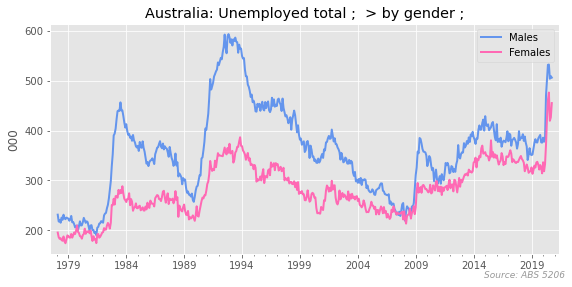

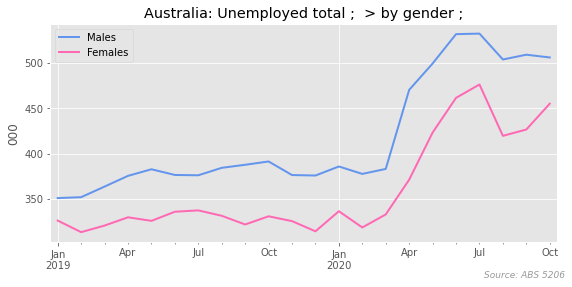

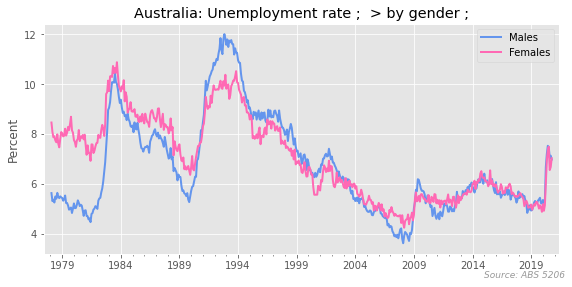

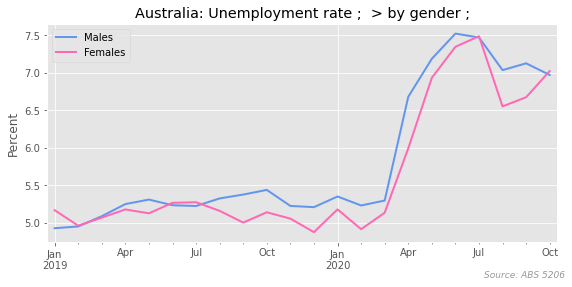

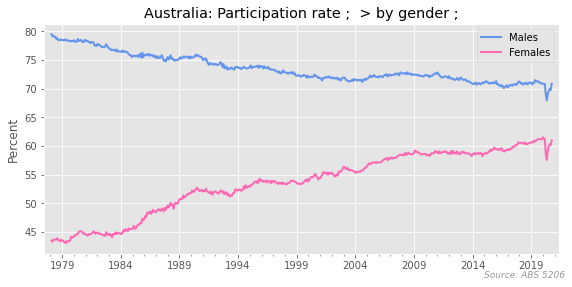

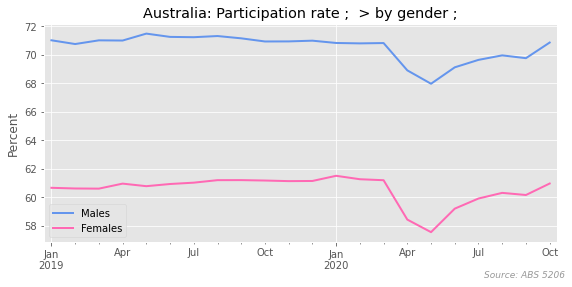

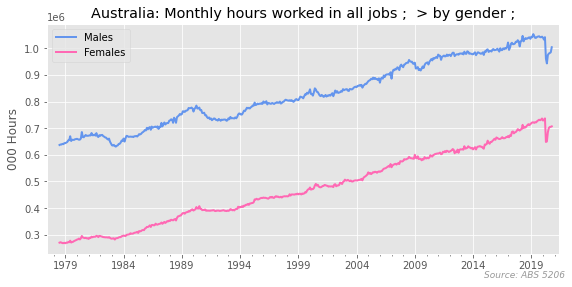

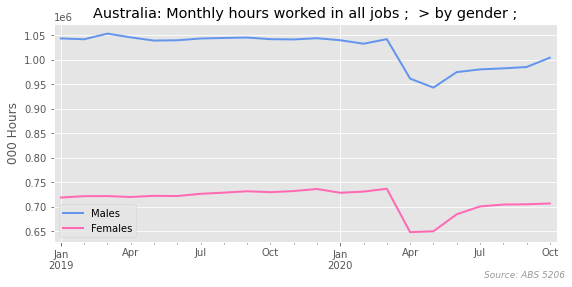

In [7]:
genders = ['Males', 'Females']
colours = ['cornflowerblue', 'hotpink']
token = 'by gender' # note: also appears in plot title
plots = {
    # data description                       # table
    f'Employed total ;  > {token} ;':       '1',
    f'> Employed part-time ;  > {token} ;': '1',
    f'> Employed full-time ;  > {token} ;': '1',
    f'Unemployed total ;  > {token} ;':     '1',
    f"Unemployment rate ;  > {token} ;":    '1',
    f"Participation rate ;  > {token} ;":   '1',
    f'Monthly hours worked in all jobs ;  > {token} ;':  '19',
}

frames = (data, data[data.index >= pd.Timestamp('2019-01-01')])
tags = ('full', 'recent')

for plot, table in plots.items():
    collection = []
    
    for gender in genders:
        this_gender = plot.replace(token, gender)
        id, units = get_identifier(meta, this_gender, 
                                   "Seasonally Adjusted", 
                                   table)
        collection.append(id)

    for frame, tag in zip(frames, tags):
        ax = frame[collection].plot(lw=2, color=colours)

        # annotate plot
        ax.legend(genders, loc='best')
        title = f"Australia: {plot}"
        finalise_plot(ax, title, units, tag, CHART_DIR)  

## Finished

In [8]:
print('Finished')

Finished
